# Amazon Food Reviews

Data Source:https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/NewCover.png)

## Excerpt 
1. Applied K-Nearest Neighbour on Different Featurization of Data viz. BOW(uni-gram,bi-gram), tfidf, Avg-Word2Vec(using Word2Vec model pretrained on Google News) and tf-idf-Word2Vec <br>
2. Used both brute & kd-tree implementation of KNN <br>
3. Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted Confusion matrix using seaborne<br>

#### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/AmazonReview.png)


### Objective:- Review Polarity
Given a review, determine the review is positive or neagative

#### Using text review to decide the polarity
Take the summary and text of review and analyze it using NLP whether the customer feedback/review is positive or negative


In [3]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [4]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" "https://storage.googleapis.com/kaggle-datasets/18/2157/database.sqlite.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1526375292&Signature=G95OD7LgGsnAoencBUsNHa3R2iIGiXOhdITLbhQVxqZ9IGS3JA9ETgbJRa3tHTguzL0ignoIz2sjQUxyY2YbcD98XR8immdcAmrFlQVA6Jm%2BBju%2BpDGjF05FpW0wGeMq6utKq2Qy8eMtm3NW%2FA%2F7m557B%2Bi3kGcBP4uaEzMk6F%2BpGaZnxcroDAcjpSj9VzU03INKPwpkbxtM%2FrWCaX748Bpgx9uKqwfrRakGR%2BRCpnMHcUukj%2FhaKKRi9QoQaTNpdRjmVB%2FqewKwDXTN8sr701yMkmqItQXBJI9Y312GqSP3Vd%2B3oleta5HZ2L9xlBFyUcLoyUEItOxI4pTjukwu1A%3D%3D" -O "database.sqlite.zip" -c

### Loading the data

In [40]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [41]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [42]:
df.shape
df['Score'].size

364171

<b>-> For EDA and Text Preprecessing Refer other ipynb notebook<b>

Score as positive or negative

In [43]:
def polarity(x):
    if x == "Positive":
        return 0
    else:
        return 1
df["Score"] = df["Score"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [44]:
#Taking Sample Data
n_samples = 25000
df_sample = df.sample(n_samples)

###Sorting as we want according to time series
df_sample.sort_values('Time',inplace=True) 
df_sample.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
117924,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,b'witty little book makes son laugh loud recit...
1144,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,0,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...,b'really good idea final product outstanding u...
117265,137932,149700,B00006L2ZT,A19JWUIRF6DXLV,Andrew J Monzon,2,4,0,1036800000,My favorite American Band!,I have been a huge fan of CVB ever since a fri...,b'huge fan cvb ever sinc friend mine loan cass...,b'huge fan cvb ever since friend mine loaned c...
316048,443664,479725,B00005U2FA,A270SG4UVKEO3X,"Susanna ""suzattorney""",23,23,0,1041638400,Easier to Use than Standard Vacu Vin,I have used both this product and the standard...,b'use product standard cheaper premium buy pro...,b'used product standard cheaper premium buy pr...
77727,87386,95119,B0000DIYIJ,A3S4XR84R8S0TV,Brook Lindquist,0,1,0,1069113600,A very cute candy!,This is definitely a cute product to order. Y...,b'definit cute product order get nice amount c...,b'definitely cute product order get nice amoun...
218787,284749,308481,B0000DIVUR,AAFD4W6P5XWNT,Nick Watson,7,8,0,1070755200,Great gift for the holidays!,My brother-in-law was thrilled with this gift ...,b'thrill gift hes superfast ship',b'thrilled gift hes superfast shipping'
334889,477821,516699,B0000DG87B,AF5EKQ4I9NHJ4,Smitty Peete,1,21,0,1071187200,Live plants from Amazon?!,Sure why not. I've purchased plants via catalo...,b'sure not ive purchas plant via catalog year ...,b'sure not ive purchased plants via catalog ye...
262407,359912,389289,B0000DYZCG,A1U4PHVIQPBCD2,Dan Murphy,2,4,0,1071187200,Excellent quality and service!,I received this as a gift. Great quality and o...,b'receiv gift great qualiti deliveri bunch clu...,b'received gift great quality delivery bunch c...
77127,86598,94281,B0000CNU2Q,A1NOWEOLKMRRXM,"T. Reinhardt ""olivia lee""",27,27,0,1071705600,The best bread crumbs...you'll never go back,Panko bread crumbs are just awesome. When use...,b'panko bread crumb awesom use bread make ligh...,b'panko bread crumbs awesome used breading mak...
178039,224637,243579,B0000DIYKD,AYHW6HJSUCSAE,"""insolent_shoeshine_grrl""",11,13,0,1072656000,Fantastic Real Licorice From The Land Down Under,I recently purchased a bag of Kookaburra Black...,b'recent purchas bag kookaburra black licoric ...,b'recently purchased bag kookaburra black lico...


In [45]:
#Saving 25000 samples in disk to as to test to test on the same sample for each of all Algo
savetofile(df_sample,"sample_25000_knn")

In [4]:
#Opening from samples from file
df_sample = openfromfile("sample_25000_knn")

# KNN Models using Different Featurization in NLP

![alt text](https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/63621/versions/2/screenshot.gif)

## Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.<br>
OR <br>
Simply,Converting a collection of text documents to a matrix of token counts

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 26976)
Test Data Size:  (7500, 26976)


In [10]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(1600, 26976) (1590, 26976)
(3190, 26976) (1590, 26976)
(4780, 26976) (1590, 26976)
(6370, 26976) (1590, 26976)
(7960, 26976) (1590, 26976)
(9550, 26976) (1590, 26976)
(11140, 26976) (1590, 26976)
(12730, 26976) (1590, 26976)
(14320, 26976) (1590, 26976)
(15910, 26976) (1590, 26976)


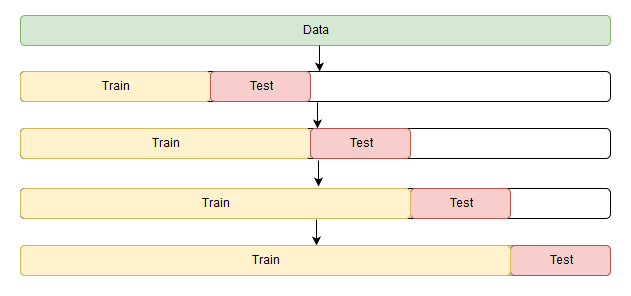

### Finding the best 'k' value using Forward Chaining Cross Validation or Time Series CV
### 1. Without Grid Search CV

In [11]:
%%time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier

#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 100

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []

for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
    if(acc_list):        
        acc_nparr = np.array(acc_list) 
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

CPU times: user 2min 46s, sys: 1min 9s, total: 3min 56s
Wall time: 5min 57s


In [12]:
savetofile(k_acc,"k_acc_uni_gram")

In [13]:
k_acc_uni_gram = openfromfile("k_acc_uni_gram")
k_acc_uni_gram

array([ 80.83018868,  84.25786164,  84.98113208,  85.29559748,
        85.34591195,  85.51572327,  85.51572327,  85.42767296,
        85.46540881,  85.33333333,  85.24528302,  85.23899371,
        85.28930818,  85.23899371,  85.19496855,  85.20125786,
        85.13207547,  85.05660377,  85.02515723,  84.98113208,
        85.02515723,  84.95597484,  84.94968553,  84.89937107,
        84.86163522,  84.8427673 ,  84.8490566 ,  84.83647799,
        84.79245283,  84.78616352,  84.7672956 ,  84.74842767,
        84.72327044,  84.71698113,  84.72955975,  84.72327044,
        84.72327044,  84.72955975,  84.74213836,  84.73584906,
        84.72327044,  84.72327044,  84.69811321,  84.67295597,
        84.66037736,  84.66037736,  84.67295597,  84.66666667,
        84.67295597,  84.66666667])

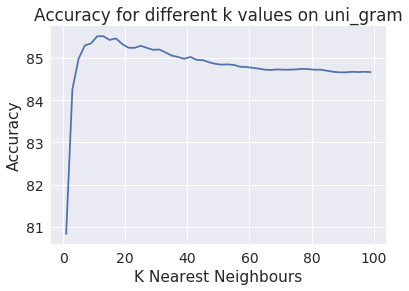

In [14]:
sns.set_style("darkgrid")
plt.plot(np.arange(1,100,2),k_acc_uni_gram)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on uni_gram")
plt.show()



With k=11-13 uni_gram has the highest accuracy of 86% <br>As we can see after a no. of neighbours the accuracy dips hence the no. of neighbours is restricted to 100 neighbours <br> 


### 2. With Grid Search CV
The above code for finding best value of 'k' can be condensed using Grid Search CV it tries all the possible params which tell it to try on and returns the best params and best accuracy 

### A.Brute Algorithm

In [16]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 85.52%


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 46.4min finished


Accuracy on test set: 84.080%
Precision on test set: 0.639
Recall on test set: 0.187
F1-Score on test set: 0.289
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



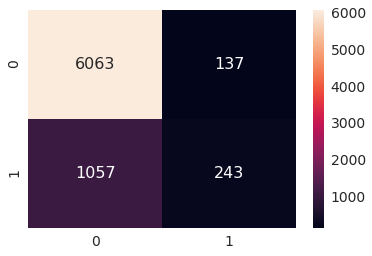

In [7]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11)*
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### B. Kd tree Algorithm

In [17]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 85.52%


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 46.3min finished


Accuracy on test set: 84.347%
Precision on test set: 0.686
Recall on test set: 0.178
F1-Score on test set: 0.283
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



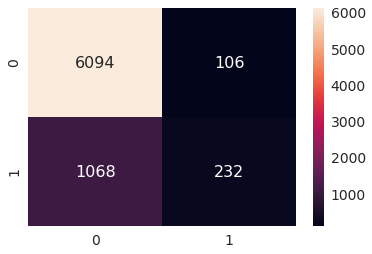

In [16]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11,algorithm='kd_tree')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### bi-gram

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 377282)
Test Data Size:  (7500, 377282)


### A.Brute Algorithm

In [19]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best HyperParameter:  {'n_neighbors': 17}
Best Accuracy: 85.77%


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 47.3min finished


Accuracy on test set: 84.613%
Precision on test set: 0.728
Recall on test set: 0.179
F1-Score on test set: 0.288
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



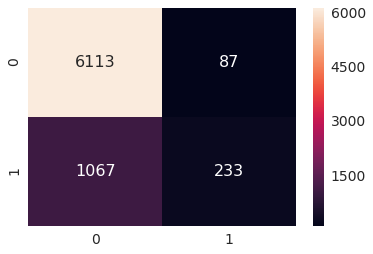

In [18]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### B. Kd tree Algorithm

In [20]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best HyperParameter:  {'n_neighbors': 17}
Best Accuracy: 85.77%


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 47.6min finished


Accuracy on test set: 84.613%
Precision on test set: 0.728
Recall on test set: 0.179
F1-Score on test set: 0.288
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



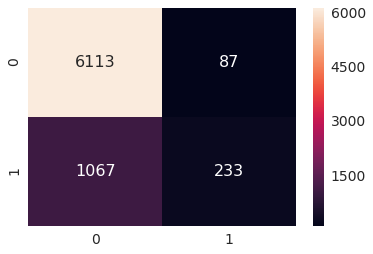

In [19]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=17,algorithm='kd_tree')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## tf-idf


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/01/11181616/image-4.png)

In [20]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 377282)
Test Data Size:  (7500, 377282)
CPU times: user 3.88 s, sys: 16 ms, total: 3.89 s
Wall time: 3.89 s


### A.Brute Algorithm

In [22]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best HyperParameter:  {'n_neighbors': 9}
Best Accuracy: 85.41%


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 47.4min finished


Accuracy on test set: 84.480%
Precision on test set: 0.801
Recall on test set: 0.139
F1-Score on test set: 0.237
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



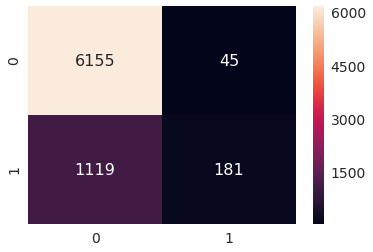

In [22]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### B. Kd tree Algorithm

In [23]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,100,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best HyperParameter:  {'n_neighbors': 9}
Best Accuracy: 85.41%


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 47.5min finished


Accuracy on test set: 84.480%
Precision on test set: 0.801
Recall on test set: 0.139
F1-Score on test set: 0.237
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



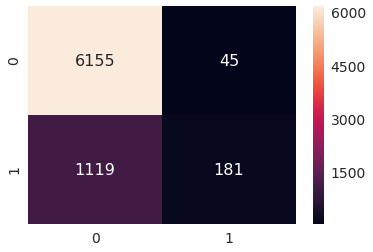

In [23]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9,algorithm='kd_tree')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Gensim
Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections, using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software packages that only target batch and in-memory processing.

## Word2Vec
[Refer Docs] :https://radimrehurek.com/gensim/models/word2vec.html 

In [24]:
from gensim.models import KeyedVectors

#Loading the model from file in the disk
w2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In [25]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

3000000

## Avg Word2Vec
* One of the most naive but good ways to convert a sentence into a vector
* Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence 

In [26]:
%%time
avg_vec_google = [] #List to store all the avg w2vec's 
# no_datapoints = 364170
# sample_cols = random.sample(range(1, no_datapoints), 20001)
for sent in df_sample['CleanedText_NoStem']:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt #Taking average of vectors sum of the particular review
#     print("avg_vec:",sent_vec)
    avg_vec_google.append(sent_vec) #Storing the avg w2vec's for each review
#     print("*******************************************************************")
# print(avg_vec_google)
avg_vec_google = np.array(avg_vec_google)

CPU times: user 12.1 s, sys: 160 ms, total: 12.3 s
Wall time: 12.3 s


In [27]:
np.isnan(avg_vec_google).any()

False

In [28]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(avg_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample['Score'].values,test_size=0.3,shuffle=False)

In [29]:
avg_vec_norm.shape

(25000, 300)

In [30]:
avg_vec_norm.max()

0.26854231895936098

### A.Brute Algorithm

In [58]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,40,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 85.61%


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 14.0min finished


Accuracy on test set: 85.107%
Precision on test set: 0.845
Recall on test set: 0.172
F1-Score on test set: 0.286
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



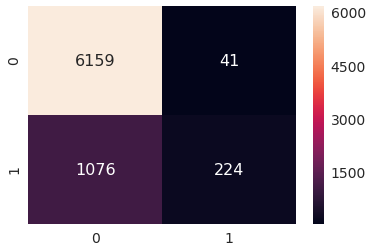

In [31]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### B. Kd tree Algorithm

In [33]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='kd_tree')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,40,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 24.8min finished


Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 85.61%


Accuracy on test set: 85.107%
Precision on test set: 0.845
Recall on test set: 0.172
F1-Score on test set: 0.286
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



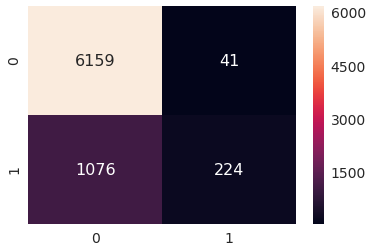

In [32]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11,algorithm='kd_tree')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Tf-idf W2Vec
* Another way to covert sentence into vectors
* Take weighted sum of the vectors divided by the sum of all the tfidf's 
<br>i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [62]:
%%time
###Sorting as we want according to time series
df_sample.sort_values('Time',inplace=True) 

###tf-idf with No Stemming
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams

tfidf_vec_new = tfidf.fit_transform(df_sample['CleanedText_NoStem'].values)

print(tfidf_vec_new.shape)

features = tfidf.get_feature_names()

(25000, 586319)
CPU times: user 6.37 s, sys: 92 ms, total: 6.46 s
Wall time: 6.93 s


In [67]:
%%time
tfidf_w2v_vec_google = []
review = 0

for sent in df_sample['CleanedText_NoStem'].values:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("w2vec:",wvec)
#             print("tfidf:",tfidf_vec_ns[review,features.index(word)])
            tfidf_vec = tfidf_vec_new[review,features.index(word)]
            sent_vec += (wvec * tfidf_vec)
            weighted_sum += tfidf_vec
        except:
#             print(review)
            pass
    sent_vec /= weighted_sum
#     print(sent_vec)
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1
tfidf_w2v_vec_google = np.array(tfidf_w2v_vec_google)
savetofile(tfidf_w2v_vec_google,"tfidf_w2v_vec_google")

CPU times: user 5h 58min 35s, sys: 2.69 s, total: 5h 58min 38s
Wall time: 5h 58min 39s


In [5]:
#Precomputed File
tfidf_w2v_vec_google = openfromfile("tfidf_w2v_vec_google")
#Loading the same samples as using precomuted file
df_sample_new = openfromfile("df_sample_new_tfidfw2vec")

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,df_sample_new['Score'].values,test_size=0.3,shuffle=False)

### A.Brute Algorithm

In [7]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,40,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.4 µs
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best HyperParameter:  {'n_neighbors': 9}
Best Accuracy: 85.08%


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 14.0min finished


Accuracy on test set: 84.920%
Precision on test set: 0.675
Recall on test set: 0.127
F1-Score on test set: 0.214
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



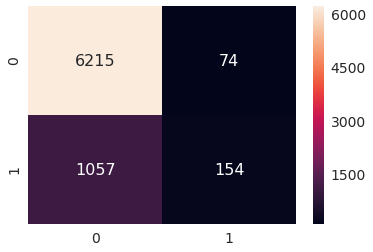

In [11]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### B. Kd tree Algorithm

In [10]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

knn = KNeighborsClassifier(algorithm='kd_tree')
# neigh = np.arange(1,100,2)
param_grid = {'n_neighbors':np.arange(1,40,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 380.7min finished


Best HyperParameter:  {'n_neighbors': 9}
Best Accuracy: 85.08%


Accuracy on test set: 84.920%
Precision on test set: 0.675
Recall on test set: 0.127
F1-Score on test set: 0.214
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



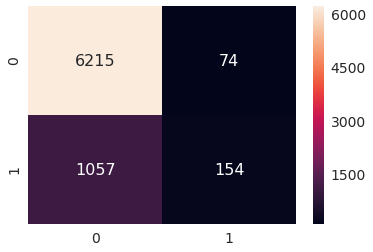

In [12]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Performance Table

![image](https://image.ibb.co/d8Ugbo/2_KNN_table.png)

## Conclusions
Note: As I have taken only 25k points(due to huge training time) the accuracy will not be the representive of the real accuracy<br>
1. Best Accuracy of 85.107% is achieved by Avg Word2Vec Featurization<br>
2. The kd-tree and brute implementation of KNN gives relatively similar results<br>
3. KNN is a very slow Algorithm compared to others takes alot of time to train<br>
4. KNN did not fair in terms of precision and F1-score. Overall KNN was not that good for this dataset